In [3]:
import math
import pandas as pd
import numpy as np
import json

from pykalman import KalmanFilter

import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots


# Data Analysis

### Data extraction and cleaning
The sample data includes order book and trades data of the pair IOTA/BTC from Binance. For convience, I apply a price multiplier as the price of IOTA/BTC is rather small. There are 100 levels of bids/asks in the order book data. Data extraction and cleaning is performed to read the csv files and get best_bid, best_ask and mid_price.

In [4]:
PRICE_ADJ_MULT = 100_000_000

def best_ask(asks):
    return np.array(json.loads(asks))[:,0].min()

def best_bid(bids):
    return np.array(json.loads(bids))[:,0].max()


In [15]:
# Data Extraction and Cleaning
df_trades=pd.read_csv('./trades.csv')
df_trades=df_trades[['timestamp', 'id', 'price', 'side', 'amount']]
df_trades['price']=df_trades.price*PRICE_ADJ_MULT

df_orders=pd.read_csv('./binance_iotabtc_orderbooks/2020-07-17.csv')
df_orders['best_ask']=df_orders['asks'].apply(best_ask)*PRICE_ADJ_MULT
df_orders['best_bid']=df_orders['bids'].apply(best_bid)*PRICE_ADJ_MULT
df_orders['mid_price']=(df_orders['best_ask']+df_orders['best_bid'])/2

display(df_orders.head(5))
display(df_trades.head(5))


,lastUpdated,asks,bids,best_ask,best_bid,mid_price
0,2020-07-17 00:00:23.225,"[[2.644e-05, 5243], [2.645e-05, 4216], [2.646e...","[[2.639e-05, 4216], [2.638e-05, 7000], [2.637e...",2644.0,2639.0,2641.5
1,2020-07-17 00:00:30.293,"[[2.645e-05, 4216], [2.646e-05, 763], [2.647e-...","[[2.638e-05, 4989], [2.637e-05, 2427], [2.6360...",2645.0,2638.0,2641.5
2,2020-07-17 00:00:30.429,"[[2.645e-05, 4216], [2.646e-05, 763], [2.647e-...","[[2.639e-05, 4216], [2.638e-05, 4989], [2.637e...",2645.0,2639.0,2642.0
3,2020-07-17 00:01:04.450,"[[2.644e-05, 11], [2.646e-05, 4978], [2.647e-0...","[[2.639e-05, 4216], [2.638e-05, 6689], [2.637e...",2644.0,2639.0,2641.5
4,2020-07-17 00:01:10.753,"[[2.643e-05, 7], [2.645e-05, 3982], [2.646e-05...","[[2.639e-05, 4216], [2.638e-05, 6689], [2.637e...",2643.0,2639.0,2641.0


,timestamp,id,price,side,amount
0,2020-07-17 00:01:10.647,19088200,2643.0,buy,4.0
1,2020-07-17 00:01:26.820,19088201,2640.0,sell,58.0
2,2020-07-17 00:01:26.825,19088202,2640.0,sell,25.0
3,2020-07-17 00:01:26.841,19088203,2640.0,sell,235.0
4,2020-07-17 00:01:26.842,19088204,2640.0,sell,36.0


### Data Visualization

In this section, I use Plotly interactive graph to visualize the order book and trade data for a given time period. 

In [16]:

df=df_trades.head(2000)

df['VWAP'] = (df['price'] * df['amount']).rolling(100).mean()/df['amount'].rolling(100).mean()

df_buy=df.query("side=='buy'")
df_sell=df.query("side=='sell'")

df1=df_orders.head(3000)

fig = make_subplots(rows=1, cols=1)

fig.add_trace(go.Scatter(x=df_buy['timestamp'], y=df_buy['price'],mode="markers",name='trade buy'),row=1, col=1)
fig.add_trace(go.Scatter(x=df_sell['timestamp'], y=df_sell['price'],mode="markers",name='trade sell'),row=1, col=1)
fig.add_trace(go.Scatter(x=df['timestamp'], y=df['VWAP'],name='VWAP',line_shape='hv'),row=1, col=1)

fig.add_trace(go.Scatter(x=df1['lastUpdated'], y=df1['best_bid'],name='best bid',line_shape='hv'),row=1, col=1)
fig.add_trace(go.Scatter(x=df1['lastUpdated'], y=df1['best_ask'],name='best ask',line_shape='hv'),row=1, col=1)
fig.add_trace(go.Scatter(x=df1['lastUpdated'], y=df1['mid_price'],name='mid price',line_shape='hv'),row=1, col=1)
# fig.add_trace(go.Scatter(x=df1['lastUpdated'], y=df1['Q1_ask'],name='Q1_ask',line_shape='hv'),row=1, col=1)
# fig.add_trace(go.Scatter(x=df1['lastUpdated'], y=df1['Q1_bid'],name='Q1_bid',line_shape='hv'),row=1, col=1)





<ipython-input-16-9a8b221e0d89>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Market Making Agent

A MarketMaker class is inplemented in market_maker.py. The class has two main functions.
1. Update fair price (Users can choose from 4 methods): \
MidPrice: Update fair value based on the market mid price \
VWAP: Calculate fair value based on trade data using VWAP \
KalmanFilter: Use a Kalman filter for fair value prediction \
RefOverride: Override fair price using reference price. Reference prices may come from other exchanges with better liquidity

2. Generate quotes
Using Avellaneda & Stoikov’s strategy to find the optimal bid/ask spreads and taking inventory risk into consideration. 

### Kalman Filter Fair Price Prediction

In [20]:

# Load and preprocess the data
data = df_orders[['lastUpdated','mid_price']]
prices = data['mid_price'].values.reshape(-1, 1)

# Initialize the Kalman filter
kf = KalmanFilter(transition_matrices=[1],
                  observation_matrices=[1],
                  initial_state_mean=prices[0, 0],
                  initial_state_covariance=1,
                  observation_covariance=1,
                  transition_covariance=0.01)

# Run the Kalman filter to obtain filtered estimates
filtered_state_means, filtered_state_covariances = kf.filter(prices)

# Extract the predicted prices from the filtered estimates
predicted_prices = filtered_state_means.flatten()

# Assess the performance of the predictions
mse = np.mean((prices.flatten() - predicted_prices) ** 2)
print("Mean Squared Error (MSE):", mse)

# Plot the actual prices and predicted prices
# plt.figure(figsize=(12, 6))
# plt.plot(data['lastUpdated'], prices.flatten(), label='Actual Prices')
# plt.plot(data['lastUpdated'], predicted_prices, label='Predicted Prices')
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.title('IOTA/BTC Price Prediction using Kalman Filter')
# plt.legend()
# plt.show()
fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Scatter(x=data['lastUpdated'], y=prices.flatten(),mode="lines",name='Actual Prices'),row=1, col=1)
fig.add_trace(go.Scatter(x=data['lastUpdated'], y=predicted_prices,mode="lines",name='Predicted Prices'),row=1, col=1)



Mean Squared Error (MSE): 1.7290305904465384


### Avellaneda and Stoikov’s strategy

In this section, we us Avellaneda & Stoikov’s strategy to deal with inventory risk and find the optimal bid and ask spreads.

Reservation price: \
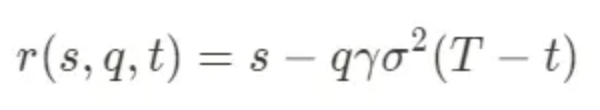

Optimal bid & ask spread: \
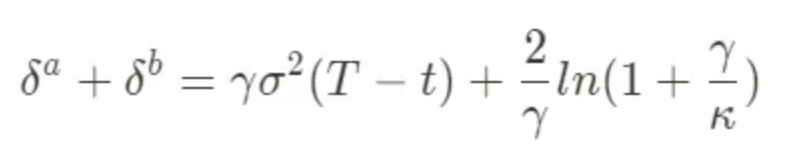


Where,

s = current market fair price \
q = quantity of assets in inventory of base asset (could be positive/negative for long/short positions) \
σ = market volatility \
T = closing time \
t = current time \
δa, δb = bid/ask spread, symmetrical → δa=δb \
γ = inventory risk aversion parameter \
κ = order book liquidity parameter \

In [ ]:
def calculate_fair_value(order_book, trade_data):
    # Calculate the weighted average price of recent trades
    trade_prices = [trade['price'] for trade in trade_data]
    trade_volumes = [trade['volume'] for trade in trade_data]
    total_volume = sum(trade_volumes)
    
    weighted_average_price = sum(price * volume for price, volume in zip(trade_prices, trade_volumes)) / total_volume
    
    # Calculate the bid-ask midpoint from the order book
    best_bid = order_book['bids'][0][0] if order_book['bids'] else None
    best_ask = order_book['asks'][0][0] if order_book['asks'] else None
    
    bid_ask_midpoint = (best_bid + best_ask) / 2 if best_bid and best_ask else None
    
    # Determine the fair value based on available data
    if weighted_average_price and bid_ask_midpoint:
        fair_value = (weighted_average_price + bid_ask_midpoint) / 2
    elif weighted_average_price:
        fair_value = weighted_average_price
    elif bid_ask_midpoint:
        fair_value = bid_ask_midpoint
    else:
        fair_value = None
    
    return fair_value

In [161]:
lk = 50
df_order['Q1_ask']=df_order.mid_price+0.5*df_order.mid_price.rolling(lk).std() #p=0.6
df_order['Q1_bid']=df_order.mid_price-0.5*df_order.mid_price.rolling(lk).std()

df_order['Q2_ask']=df_order.mid_price+1*df_order.mid_price.rolling(lk).std() #p=0.3
df_order['Q2_bid']=df_order.mid_price-1*df_order.mid_price.rolling(lk).std()

df_order['Q3_ask']=df_order.mid_price+2*df_order.mid_price.rolling(lk).std() #p=0.05
df_order['Q3_bid']=df_order.mid_price-2*df_order.mid_price.rolling(lk).std()

In [184]:
df_trades

,timestamp,id,price,side,amount
0,2020-07-17 00:01:10.647,19088200,2643.0,buy,4.0
1,2020-07-17 00:01:26.820,19088201,2640.0,sell,58.0
2,2020-07-17 00:01:26.825,19088202,2640.0,sell,25.0
3,2020-07-17 00:01:26.841,19088203,2640.0,sell,235.0
4,2020-07-17 00:01:26.842,19088204,2640.0,sell,36.0
...,...,...,...,...,...
96498,2020-07-30 23:54:05.293,19187367,2707.0,sell,181.0
96499,2020-07-30 23:57:25.885,19187368,2709.0,buy,167.0
96500,2020-07-30 23:58:00.690,19187369,2706.0,sell,21.0
96501,2020-07-30 23:58:00.697,19187370,2705.0,sell,43.0


In [183]:
prices.flatten()


array([2641.5, 2641.5, 2642. , ..., 2630.5, 2630. , 2629.5])

In [182]:
predicted_prices

array([2641.5       , 2641.5       , 2641.62901086, ..., 2630.89156691,
       2630.80675667, 2630.68245155])

In [109]:

df['VWAP'] = (df['price'] * df['amount']).rolling(100).mean()/df['amount'].rolling(100).mean()


<ipython-input-109-9448de102d24>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,timestamp,id,price,side,amount,Cumulative_Price_Volume,Cumulative_Volume,VWAP
0,2020-07-17 00:01:10.647,19088200,0.000026,buy,4.0,0.000106,4.0,NaN
1,2020-07-17 00:01:26.820,19088201,0.000026,sell,58.0,0.001637,62.0,NaN
2,2020-07-17 00:01:26.825,19088202,0.000026,sell,25.0,0.002297,87.0,NaN
3,2020-07-17 00:01:26.841,19088203,0.000026,sell,235.0,0.008501,322.0,NaN
4,2020-07-17 00:01:26.842,19088204,0.000026,sell,36.0,0.009451,358.0,NaN
...,...,...,...,...,...,...,...,...
1995,2020-07-17 17:26:03.499,19090195,0.000026,sell,1437.0,42.995723,1632050.0,0.000026
1996,2020-07-17 17:26:03.708,19090196,0.000026,sell,195.0,43.000851,1632245.0,0.000026
1997,2020-07-17 17:27:28.607,19090197,0.000026,buy,5335.0,43.141215,1637580.0,0.000026
1998,2020-07-17 17:28:47.908,19090198,0.000026,sell,1901.0,43.191211,1639481.0,0.000026


In [119]:
df_order['TQ_sell']=df_order.mid_price+df_order.mid_price.rolling(10).std()
df_order['TQ_buy']=df_order.mid_price-df_order.mid_price.rolling(10).std()

In [118]:
df_order.mid_price.rolling(10).std()

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
4761    0.0
4762    0.0
4763    0.0
4764    0.0
4765    0.0
Name: mid_price, Length: 4766, dtype: float64

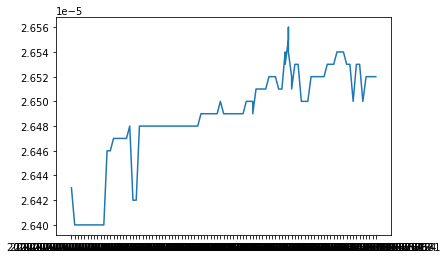

In [41]:
import matplotlib.pyplot as plt

df=df_trades.head(100)
# Plot the DataFrame
plt.plot(df['timestamp'], df['price'])

plt.show()

# Reference
https://blog.hummingbot.org/2021-04-avellaneda-stoikov-market-making-strategy/
